# Data loading

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import keras
import tensorflow as tf
import PIL

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train

,label,latitude,longitude,year,example_path
0,0,-2.051853,111.826093,2001,train_test_data/train/1297.png
1,2,-1.989349,105.309496,2013,train_test_data/train/1199.png
2,0,1.223256,100.702217,2014,train_test_data/train/1348.png
3,0,-2.342948,103.890226,2008,train_test_data/train/2214.png
4,0,-0.126555,101.758175,2011,train_test_data/train/2220.png
...,...,...,...,...,...
1709,0,3.819464,117.636112,2016,train_test_data/train/550.png
1710,0,-1.809594,111.531951,2005,train_test_data/train/2264.png
1711,1,0.443397,112.200163,2012,train_test_data/train/1486.png
1712,2,-1.978349,101.970148,2012,train_test_data/train/1170.png


# Exploration

In [4]:
img = cv2.imread("train_test_data/train/1348.png")

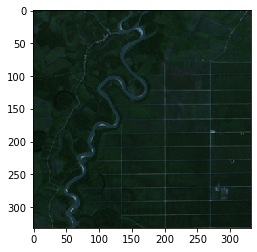

In [5]:
from matplotlib import pyplot as plt
plt.imshow(img, interpolation='nearest')
plt.show()

In [6]:
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
img_aug = cv2.filter2D(img, -1, kernel)

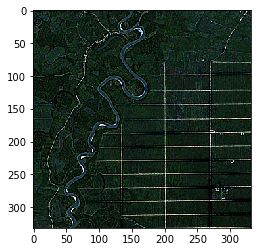

In [7]:
from matplotlib import pyplot as plt
plt.imshow(img_aug, interpolation='nearest')
plt.show()

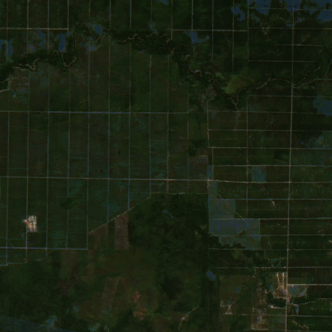

In [8]:
from PIL import Image

Image.open(train[train['label'] == 0].sample()['example_path'].iloc[0])

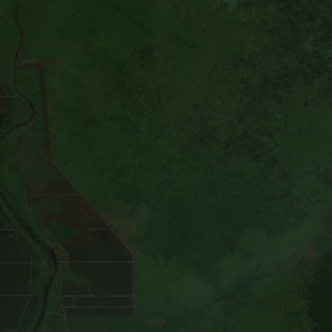

In [9]:
Image.open(train[train['label'] == 1].sample()['example_path'].iloc[0])

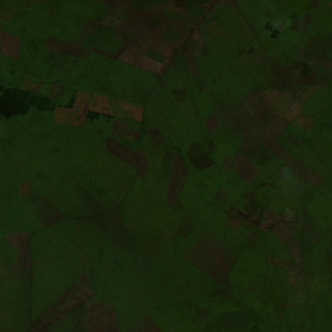

In [10]:
Image.open(train[train['label'] == 2].sample()['example_path'].iloc[0])

# Preprocessing

In [11]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train, test_size=0.2, random_state=42)

In [12]:
train0 = train[train["label"] == 0]
train1 = train[train["label"] == 1]
train2 = train[train["label"] == 2]

In [13]:
BUFFER_SIZE = 4000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

ds0 = make_ds(train0["example_path"],train0["label"])
ds1 = make_ds(train1["example_path"],train1["label"])
ds2 = make_ds(train2["example_path"],train2["label"])

train_ds = tf.data.Dataset.sample_from_datasets([ds0, ds1, ds2], weights=[0.34, 0.33, 0.33])

In [14]:
valid0 = valid[valid["label"] == 0]
valid1 = valid[valid["label"] == 1]
valid2 = valid[valid["label"] == 2]

In [15]:
dds0 = make_ds(valid0["example_path"],valid0["label"])
dds1 = make_ds(valid1["example_path"],valid1["label"])
dds2 = make_ds(valid2["example_path"],valid2["label"])

valid_ds = tf.data.Dataset.sample_from_datasets([dds0, dds1, dds2], weights=[0.34, 0.33, 0.33])

In [16]:
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def kernel_f(image):
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    image = image.numpy()
    image = cv2.filter2D(image, -1, kernel)
    return tf.convert_to_tensor(image)

def preprocess(image, label):
    image = tf.io.read_file(image)
    image = tf.io.decode_png(image, channels=3,dtype=tf.dtypes.uint16)
    image = tf.cast(image,dtype=tf.float64)
    image = tf.py_function(kernel_f, [image], tf.float64)
    image = random_crop(image)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    resized_image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.xception.preprocess_input(resized_image)
    final_image = image/255.
    return final_image, label

In [17]:
batch_size = 32
train_set = train_ds.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_set = valid_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


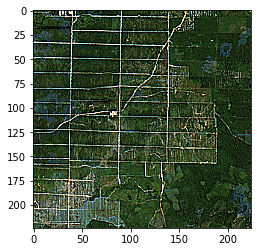

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


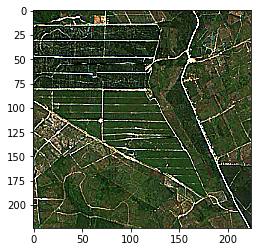

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


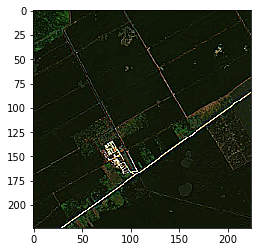

In [18]:
count=0
for image, label in valid_set:
    if count > 2:
        break
    count += 1
    plt.imshow(image[count], interpolation='nearest')
    plt.show()

# Training

In [19]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(3, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [20]:
for layer in base_model.layers:
    layer.trainable = False

In [21]:
dataset_size = 4000

es = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode = "max", verbose=1, patience=5)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])
history = model.fit(train_set,
                    callbacks=[es],
                    steps_per_epoch=60,
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=50)

Epoch 1/50
60/60 [==============================] - 42s 598ms/step - loss: 0.8888 - accuracy: 0.5729 - val_loss: 0.7975 - val_accuracy: 0.6458
Epoch 2/50
60/60 [==============================] - 35s 585ms/step - loss: 0.8063 - accuracy: 0.6453 - val_loss: 0.7887 - val_accuracy: 0.6597
Epoch 3/50
60/60 [==============================] - 34s 573ms/step - loss: 0.7352 - accuracy: 0.6870 - val_loss: 0.7477 - val_accuracy: 0.6736
Epoch 4/50
60/60 [==============================] - 33s 549ms/step - loss: 0.7248 - accuracy: 0.6839 - val_loss: 0.7103 - val_accuracy: 0.6927
Epoch 5/50
60/60 [==============================] - 28s 473ms/step - loss: 0.7014 - accuracy: 0.7094 - val_loss: 0.7292 - val_accuracy: 0.6753
Epoch 6/50
60/60 [==============================] - 28s 468ms/step - loss: 0.6695 - accuracy: 0.7240 - val_loss: 0.7299 - val_accuracy: 0.6927
Epoch 7/50
60/60 [==============================] - 28s 472ms/step - loss: 0.6616 - accuracy: 0.7255 - val_loss: 0.7147 - val_accuracy: 0.6962

# Predictions

In [50]:
test_set = tf.convert_to_tensor(test["example_path"])

In [52]:
def preprocess_test(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_png(image, channels=3,dtype=tf.dtypes.uint16)
    image = tf.cast(image,dtype=tf.float64)
    image = tf.py_function(kernel_f, [image], tf.float64)
    image = random_crop(image)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    resized_image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.xception.preprocess_input(resized_image)
    final_image = image/255.
    return final_image

In [ ]:
tt = tf.map_fn(fn = preprocess_test, elems = test_set, dtype=tf.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


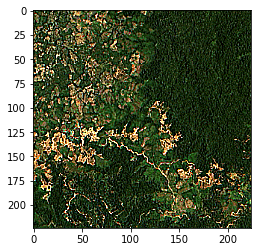

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


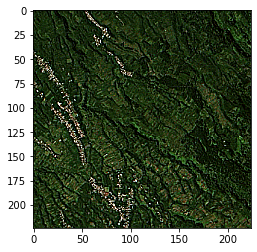

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


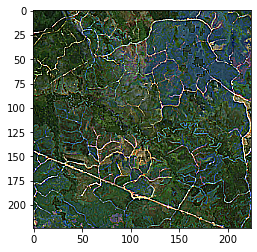

In [58]:
count=0
for image in tt:
    if count > 2:
        break
    count += 1
    plt.imshow(image, interpolation='nearest')
    plt.show()

In [59]:
pred = model.predict(tt)

In [61]:
pred = np.argmax(pred, axis=1)

In [66]:
l = [(i,pred[i]) for i in range(len(pred))]
d = dict(target=dict(l))

In [68]:
final = pd.DataFrame(d)
final.to_json(r'predictions.json')